In [1]:
# Imports
%matplotlib inline
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

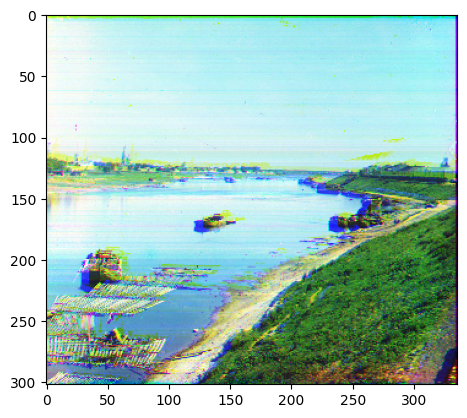

In [2]:
img_ = io.imread("rusian_empire.png")[::10, ::10]
x1 = 20; y1 = 20;
x2 = 25; y2 = 333;
x3 = 24; y3 = 647;
w = 336; h = 302;

img = np.stack([
    img_[y3-2:y3+h-2,x3-1:x3+w-1],
    img_[y2-2:y2+h-2,x2-1:x2+w-1],
    img_[y1-2:y1+h-2,x1-1:x1+w-1],
], axis=2)

im = np.apply_along_axis(lambda x: x.astype(np.double) / x.max(), arr=img, axis=1)
plt.imshow(im)

In [3]:

def roll(img,dispX,dispY):
    
    copyX = img[:,0:-dispX]
    img = np.concatenate((img[:,-dispX:img.shape[1]],copyX),axis=1)
    
    copyY = img[0:-dispY,:]
    img2 = np.concatenate((img[-dispY:img.shape[0],:],copyY),axis=0)
    
    return img2

In [4]:
def draw_square(image, center, radius, color=(1, 0, 0)):
    """
    Dibuja un cuadrado en la imagen dada con un punto central y un radio especificado.

    Args:
    image (numpy.ndarray): La imagen en la que se dibujará el cuadrado.
    center (tuple): Una tupla (x, y) que representa el punto central del cuadrado.
    radius (int): El radio del cuadrado.
    color (tuple): Una tupla (R, G, B) que representa el color del cuadrado. Por defecto es rojo.

    Returns:
    numpy.ndarray: La imagen con el cuadrado dibujado.
    """
    image = image.copy()
    x, y = center
    x1, y1 = max(0, x - radius), max(0, y - radius)
    x2, y2 = min(image.shape[1], x + radius), min(image.shape[0], y + radius)

    # Draw the borders of the square
    image[y1:y2, x1] = color  # Left border
    image[y1:y2, x2-1] = color  # Right border
    image[y1, x1:x2] = color  # Top border
    image[y2-1, x1:x2] = color  # Bottom border

    return image

In [5]:
def print_img(img, c):
    """
        Esta funcion recibe una imagen y un canal y devuelve la imagen con el canal sobrante en 0 (negro)
        La utilizo para mostrar la desviacion de los canales.
    """
    img = img.copy()
    c = 1 if c == 2 else 2
    img[..., c] = 0
    return img

In [6]:
from scipy.signal import correlate2d

def apply_cross_correlation(img, coords, title: str, width=15, search=3):
    """
    Aplica correlación cruzada a los canales de una imagen para encontrar
    y corregir desalineaciones entre ellos.
    
    params:
        img (ndarray): Imagen de entrada.
        coords (tuple): Coordenadas iniciales para buscar alineación.
        title (str): Título de la imagen.
        width (int, opcional): Tamaño del bloque de búsqueda. Por defecto es 15.
        search (int, opcional): Rango de búsqueda adicional para la correlación cruzada. Por defecto es 3.
    
    returns:
        img (ndarray): Imagen alineada.
        displacement_coordinates (list): Lista de tuplas (dx, dy) con las coordenadas de desplazamiento.
    """
    img = img.copy()

    y, x = coords
    search = search + width  # Bloque de búsqueda es 3 píxeles más grande

    # Normalizamos el template y el bloque
    template = img[x - search:x + search, y - search:y + search]
    template = (template - template.min()) / template.max()
    template -= template.mean()
    
    bloque = img[x - width:x + width, y - width:y + width]
    bloque = (bloque - bloque.min()) / bloque.max()
    bloque -= bloque.mean()

    # Definimos la figura
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    fig.suptitle(title, fontsize=20)

    channels = {1: 'Green', 2: 'Blue'}

    displacement_coordinates = []  # Lista de tuplas (dx, dy)

    for c in range(1, 3):

        corr = correlate2d(bloque[..., 0], template[..., c])

        i = 0
        # Encontramos el centro de la NCC para encontrar el vector
        axes[c-1][i].set_title(f"CCN Red-{channels[c]}")
        axes[c-1][i].imshow(corr, cmap='jet')
        ymax, xmax = np.where(corr == corr.max())

        # Conseguimos las coordenadas de desplazamiento
        dx, dy = xmax[0] - (corr.shape[0] // 2), ymax[0] - (corr.shape[1] // 2)
        displacement_coordinates.append((dx, dy))

        print(f"Canal {channels[c]} desalineado en [x, y]: {dx}, {dy}")

        i += 1
        axes[c-1][i].set_title(f"Canales Red-{channels[c]} Desalineados")
        axes[c-1][i].imshow(img[x - width:x + width, y - width:y + width, c], cmap='jet')

        img[..., c] = roll(img[..., c], dx, dy)  # Desplazamos la imagen

        i += 1
        
        axes[c-1][i].set_title(f"Alineación del canal Red-{channels[c]} por dx: {dx}, dy: {dy}")
        axes[c-1][i].imshow(img[x - width:x + width, y - width:y + width, c], cmap='jet')

    return img, displacement_coordinates

Canal Green desalineado en [x, y]: -1, 0
Canal Blue desalineado en [x, y]: -8, 3


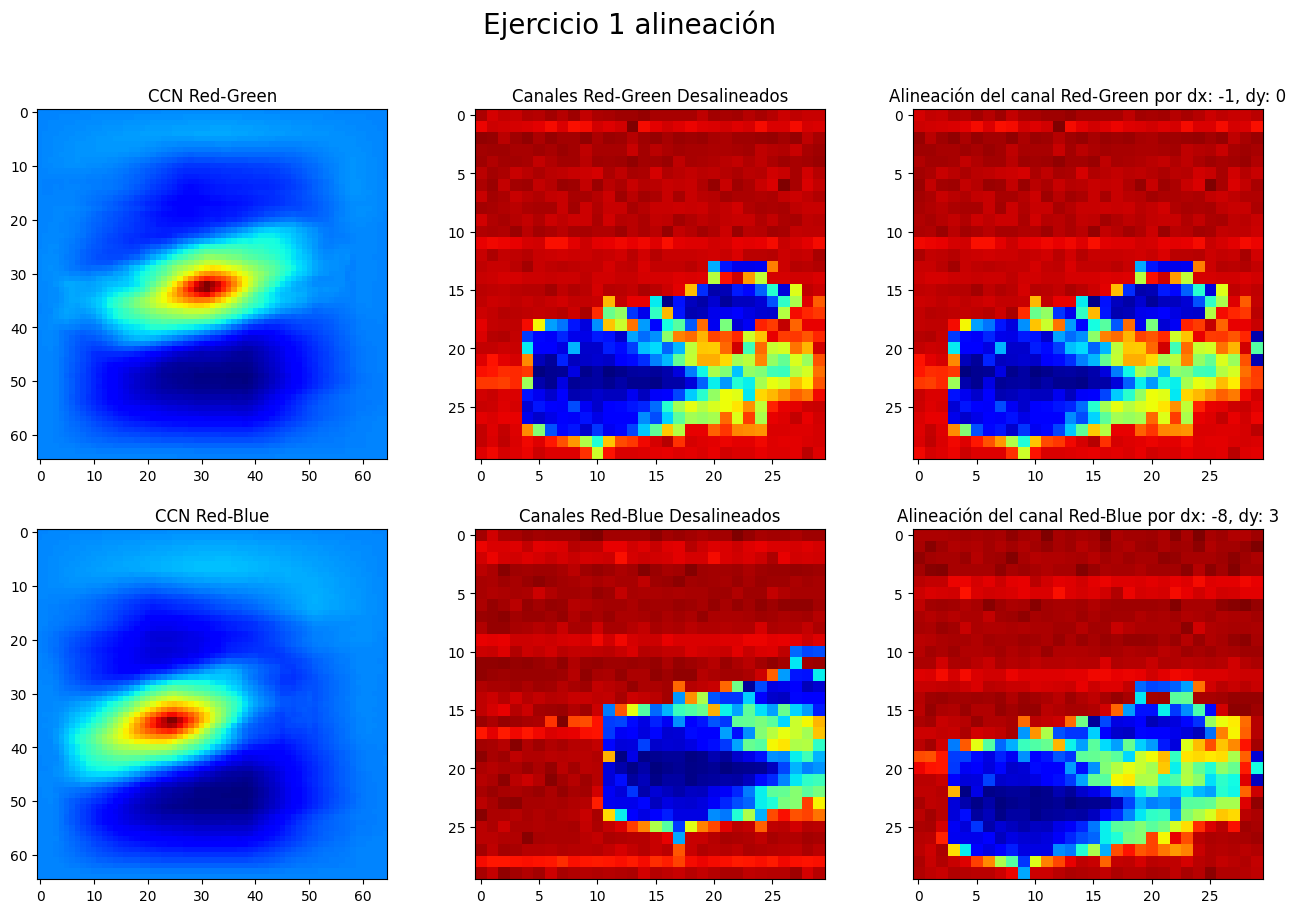

In [7]:
# Aplicamos la funcion
img_aligned, dc = apply_cross_correlation(im, (132, 165), "Ejercicio 1 alineación")

# Ejercicio 2
Para comprobar que el la alineación funciona, he hecho algunas pruebas controladas. Donde podemos ver como se comporta el algoritmo dados diferentes inputs.

## Prueba 1. Tenemos una cruz blanca desalienada en los 3 canales.
### Cruz_1
    Esta imagen tiene la cruz desalineada por 2px. Que caen en columnas y filas pares por la forma de la imagen, por lo que al reducir la imagen a la mitad en la primera fase de la piramide, estas lineas se conservarán.

### Cruz_2
    - Se han desplazado las cruzes de forma que una queda en la columna 47, por lo que al hacer la imagen la mitad más pequeña, esta linea desaparecerá.
    - Además la cruz azul queda fuera del bloque cuando la imagen NO es reducida.

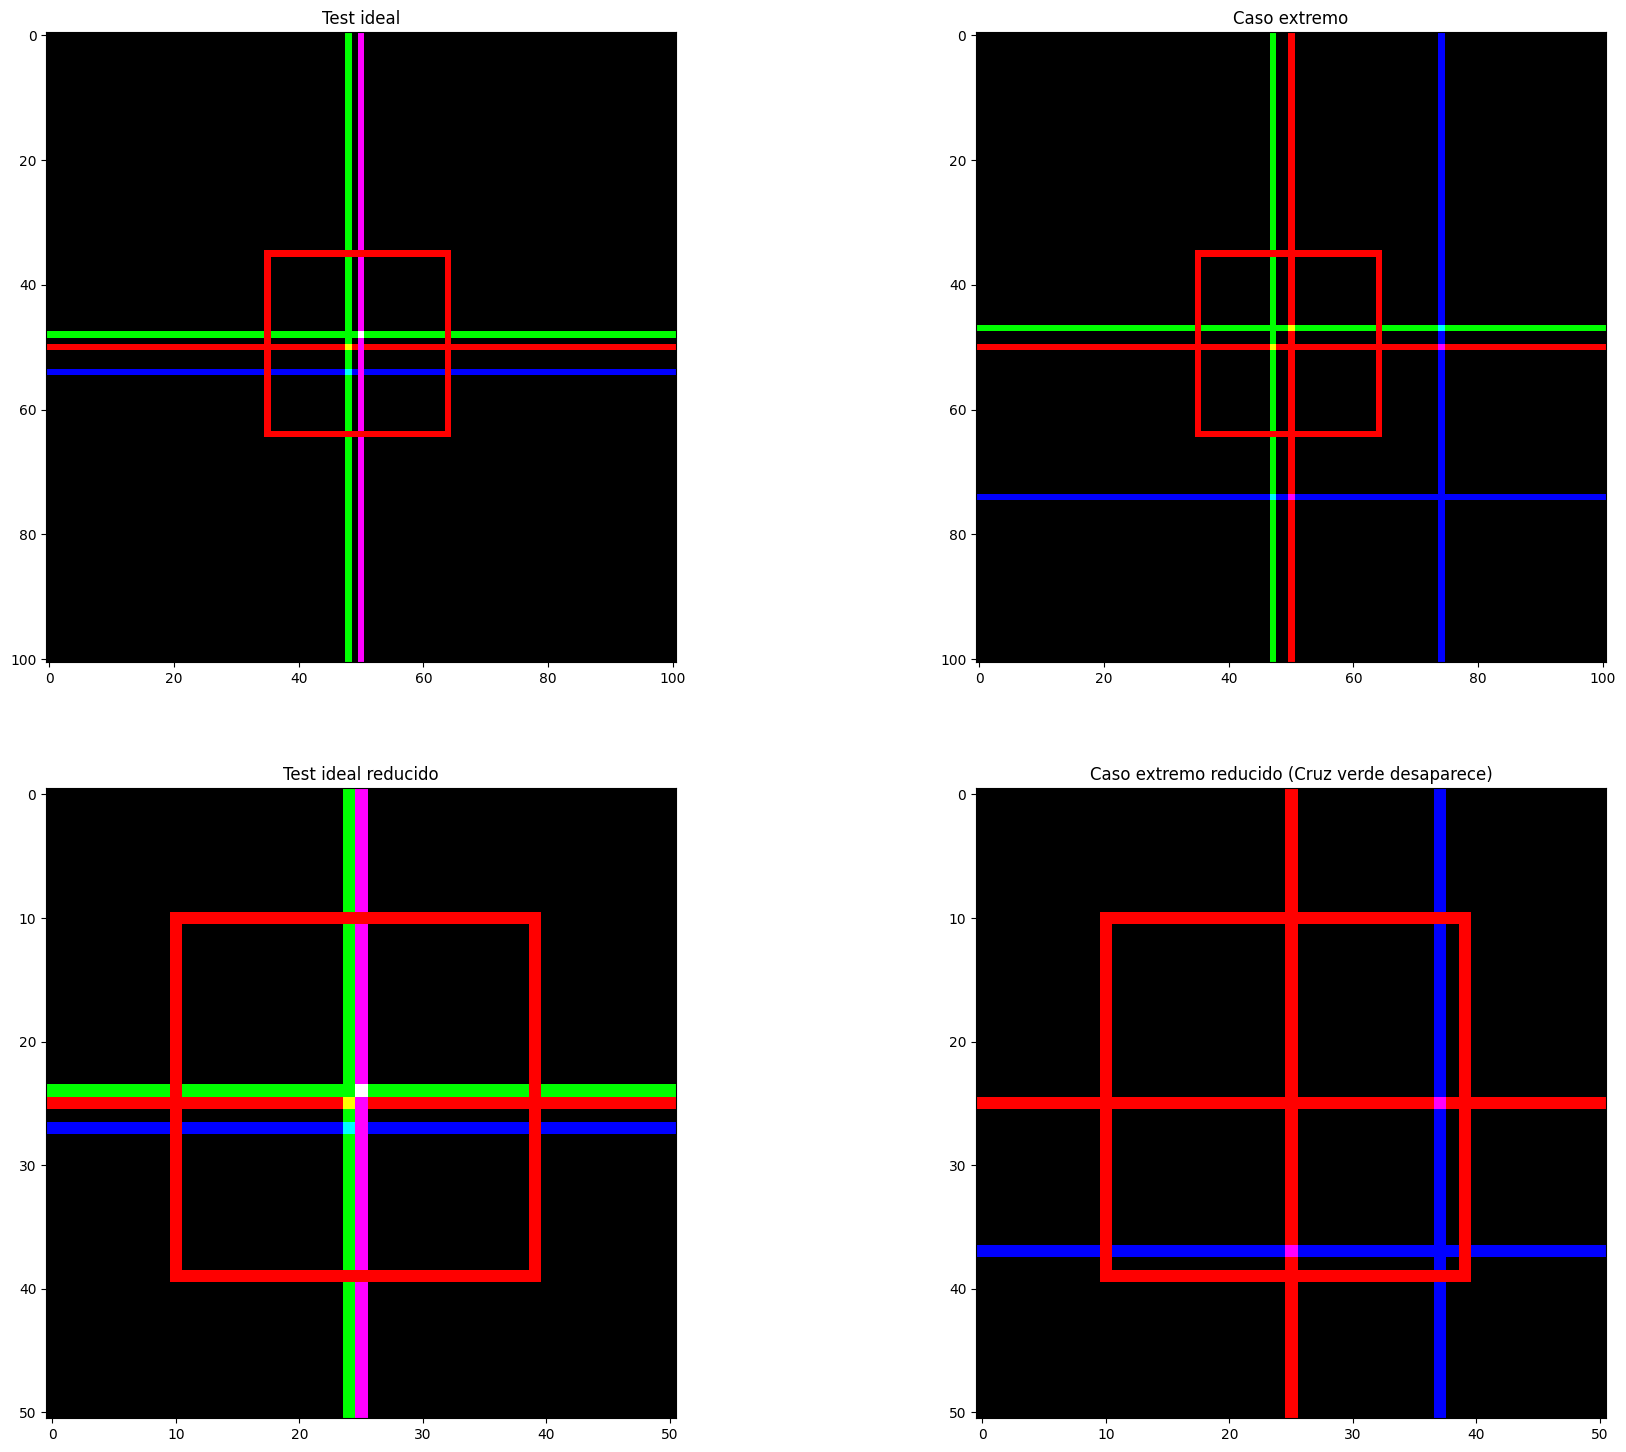

In [8]:
# Crear una imagen de 101x101 píxeles con todos los valores en 0 (negro)
cruz_1 = np.zeros((101, 101, 3))
cruz_2 = cruz_1.copy()

# Cruz roja en el medio
cruz_1[50, :, 0] = 1
cruz_1[:, 50, 0] = 1

# Dibujar una cruz en el canal verde desplazada
cruz_1[48, :, 1] = 1
cruz_1[:, 48, 1] = 1

# Dibujar una cruz en el canal azul desplazada
cruz_1[54, :, 2] = 1
cruz_1[:, 50, 2] = 1

# Dibujar una cruz en el canal rojo
cruz_2[50, :, 0] = 1
cruz_2[:, 50, 0] = 1

# Dibujar una cruz en el canal verde desplazada
""" ESTA CRUZ DESAPARECE AL HACER cruz_2[::2, ::2]"""
cruz_2[47, :, 1] = 1
cruz_2[:, 47, 1] = 1

# Dibujar una cruz en el canal azul desplazada
"""ESTA CRUZ NO ENTRA DENTO DEL BLOQUE CUANDO LA IMGEN NO ES REDUCIDA"""
cruz_2[74, :, 2] = 1
cruz_2[:, 74, 2] = 1

# Mostrar las dos imágenes con los títulos correspondientes
fig, axes = plt.subplots(2, 2, figsize=(22, 18))

coords = (50, 50) # Coordenadas que vamos a utilizar, centro de la imagen
width = 15 # Tamaño de ventana que vamos a usar

axes[0][0].imshow(draw_square(cruz_1, center=coords, radius=width))
axes[0][0].set_title('Test ideal')

axes[0][1].imshow(draw_square(cruz_2, center=coords, radius=width))
axes[0][1].set_title('Caso extremo')

axes[1][0].imshow(draw_square(cruz_1[::2, ::2], center=(25, 25), radius=width))
axes[1][0].set_title('Test ideal reducido')

axes[1][1].imshow(draw_square(cruz_2[::2, ::2], center=(25, 25), radius=width))
axes[1][1].set_title('Caso extremo reducido (Cruz verde desaparece)')

plt.show()

In [9]:
from scipy.ndimage import gaussian_filter

def pyramidal_descomposition(image, coords: tuple, titles: list[str], width = 15, search = 3, gauss = True):

    """
        Realiza una descomposición piramidal en una imagen para encontrar y aplicar coordenadas de desplazamiento.
        Parameters
        ----------
        image : 
            La imagen de entrada sobre la cual realizar la descomposición.
        coords : 
            Las coordenadas desde donde comenzar la búsqueda.
        width : 
            El ancho de la ventana de búsqueda. Por defecto es 15.
        search ): 
            El rango de búsqueda para la correlación cruzada. Por defecto es 3.
        gauss : 
            Si se debe aplicar el filtro Gaussiano. Por defecto es True.
   
        Returns
        -------
        final_img (ndarray): 
            La imagen después de aplicar el desplazamiento.
    """

    image = image.copy()
    
    if gauss:
        # Aplicamos una funcion de Gauss con sigma 1 a la imagen
        gauss_img = gaussian_filter(image, sigma=1, axes=(0, 1))
    else: 
        gauss_img = image

    # Aplicamos el roll a la imagen reducida
    _, displacement_coordinates = apply_cross_correlation(gauss_img[::2, ::2],
                                                           (coords[0] // 2, coords[1] // 2),
                                                           titles[0],
                                                           width, 
                                                           search)

    # Hacemos el roll a la imagen original | Tenemos que multiplicar por 2 porque la imagen fue reducida
    # Primero canal Green
    image[..., 1] = roll(image[..., 1], displacement_coordinates[0][0] * 2, displacement_coordinates[0][1] * 2)

    # Despues canal Blue
    image[..., 2] = roll(image[..., 2], displacement_coordinates[1][0] * 2, displacement_coordinates[1][1] * 2)

    # Aplicamos cross correlation  a la imagen original con la misma window size
    final_img, _ = apply_cross_correlation(image.copy(), coords, titles[1], width, search)

    return final_img

## Prueba 1 | Vamos a ejecutar la Cruz 1 con y sin gauss
### Sin Gauss
Se ajustan todos los canales en la primera iteración sin problema, la segunda iteración es inútil.

### Con Gauss
Pasa exactamente lo mismo, se alinean en la primera iteración. Ya que los pixeles se ven claramente y no hemos perdido información al reducir el tamaño de la imagen.

Canal Green desalineado en [x, y]: 1, 1
Canal Blue desalineado en [x, y]: 0, -2
Canal Green desalineado en [x, y]: 0, 0
Canal Blue desalineado en [x, y]: 0, 0
Canal Green desalineado en [x, y]: 1, 1
Canal Blue desalineado en [x, y]: 0, -2
Canal Green desalineado en [x, y]: 0, 0
Canal Blue desalineado en [x, y]: 0, 0


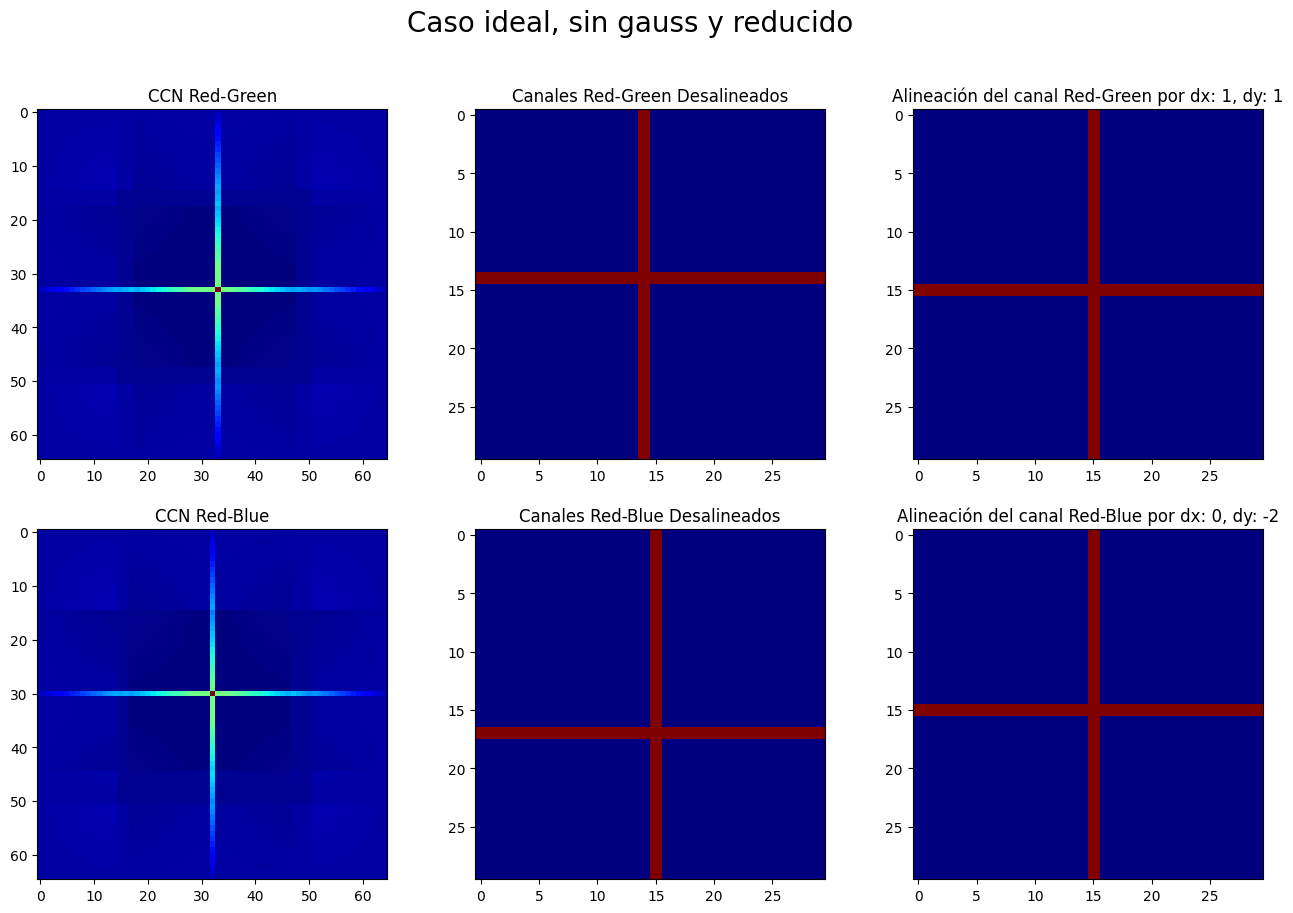

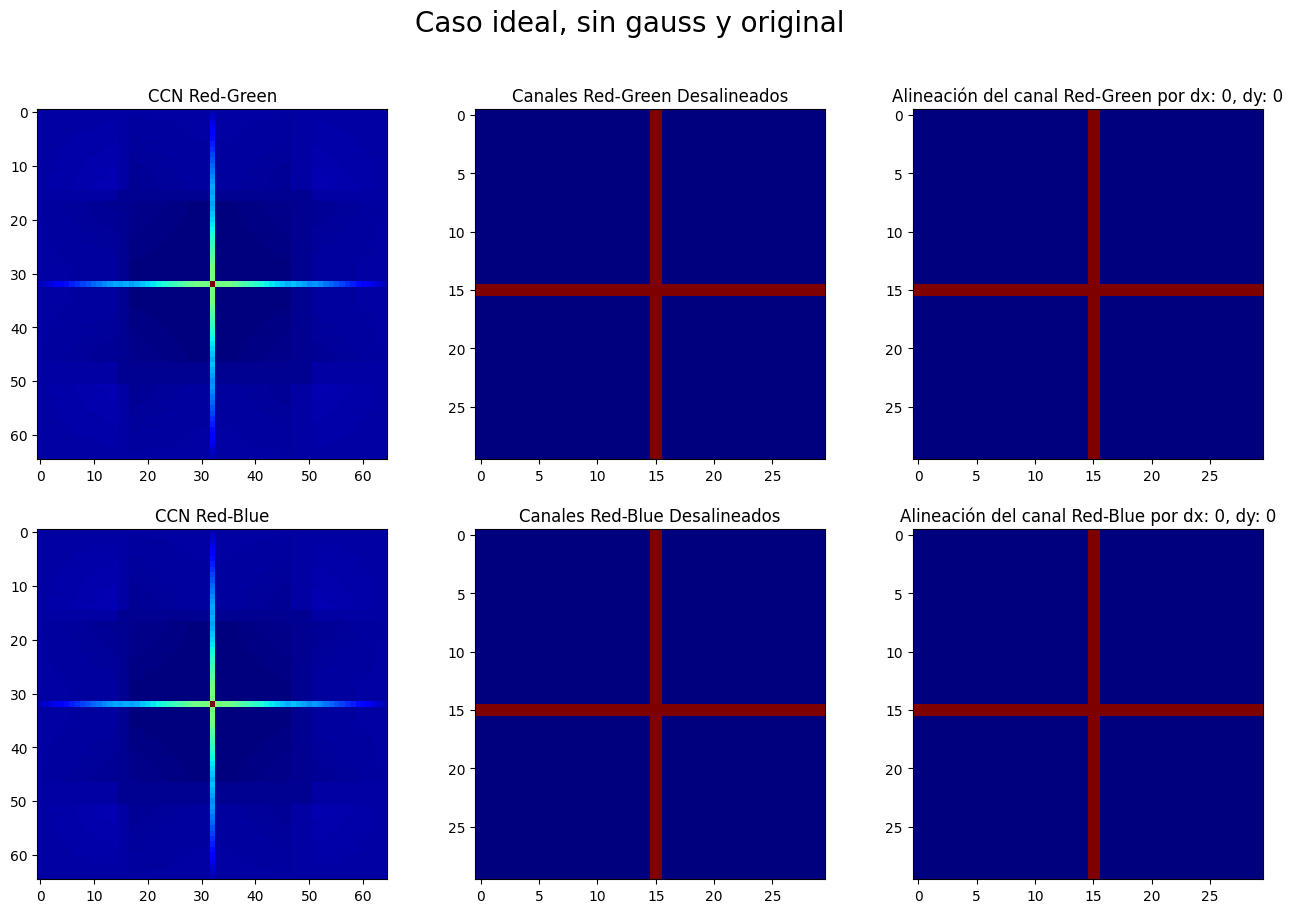

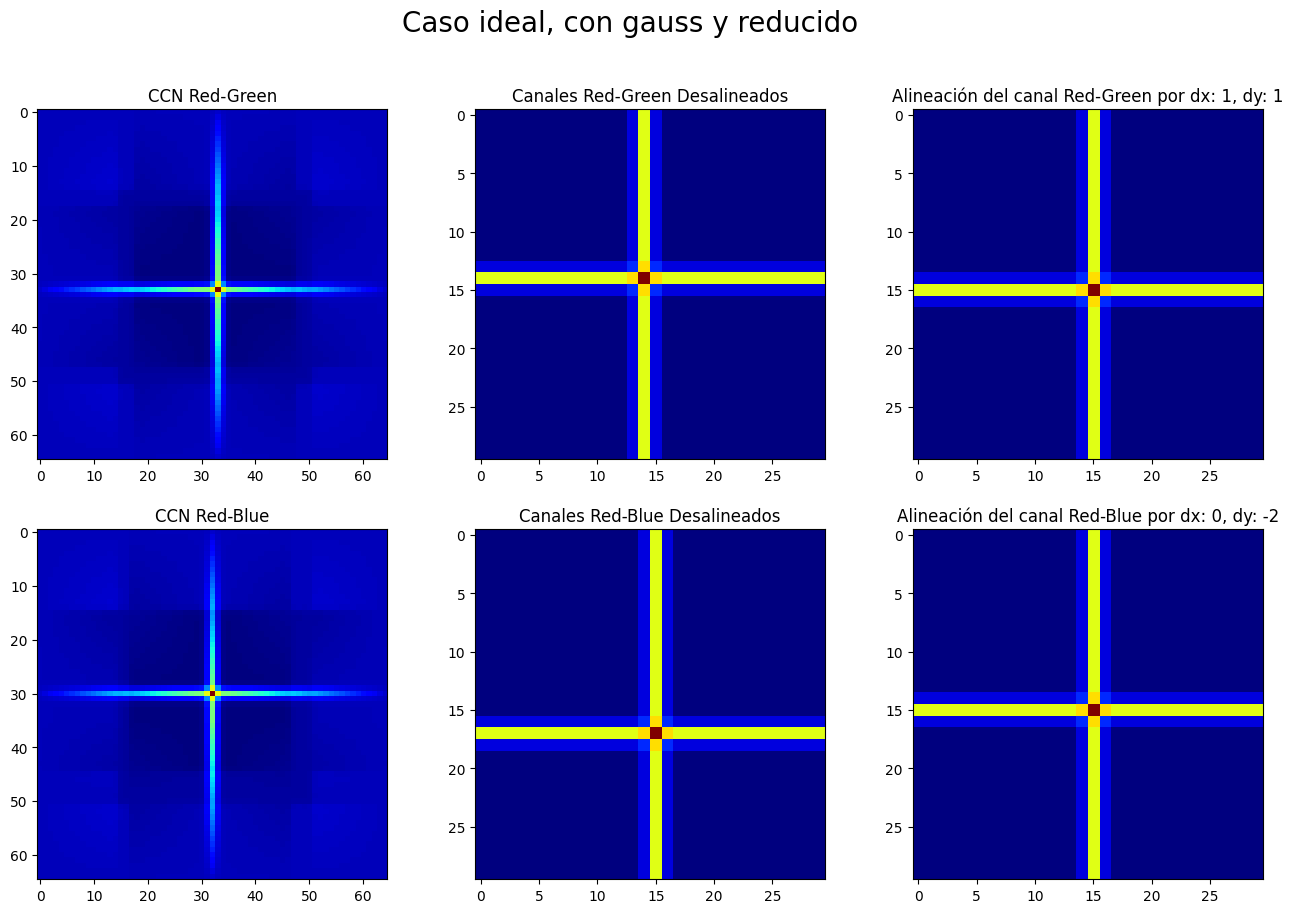

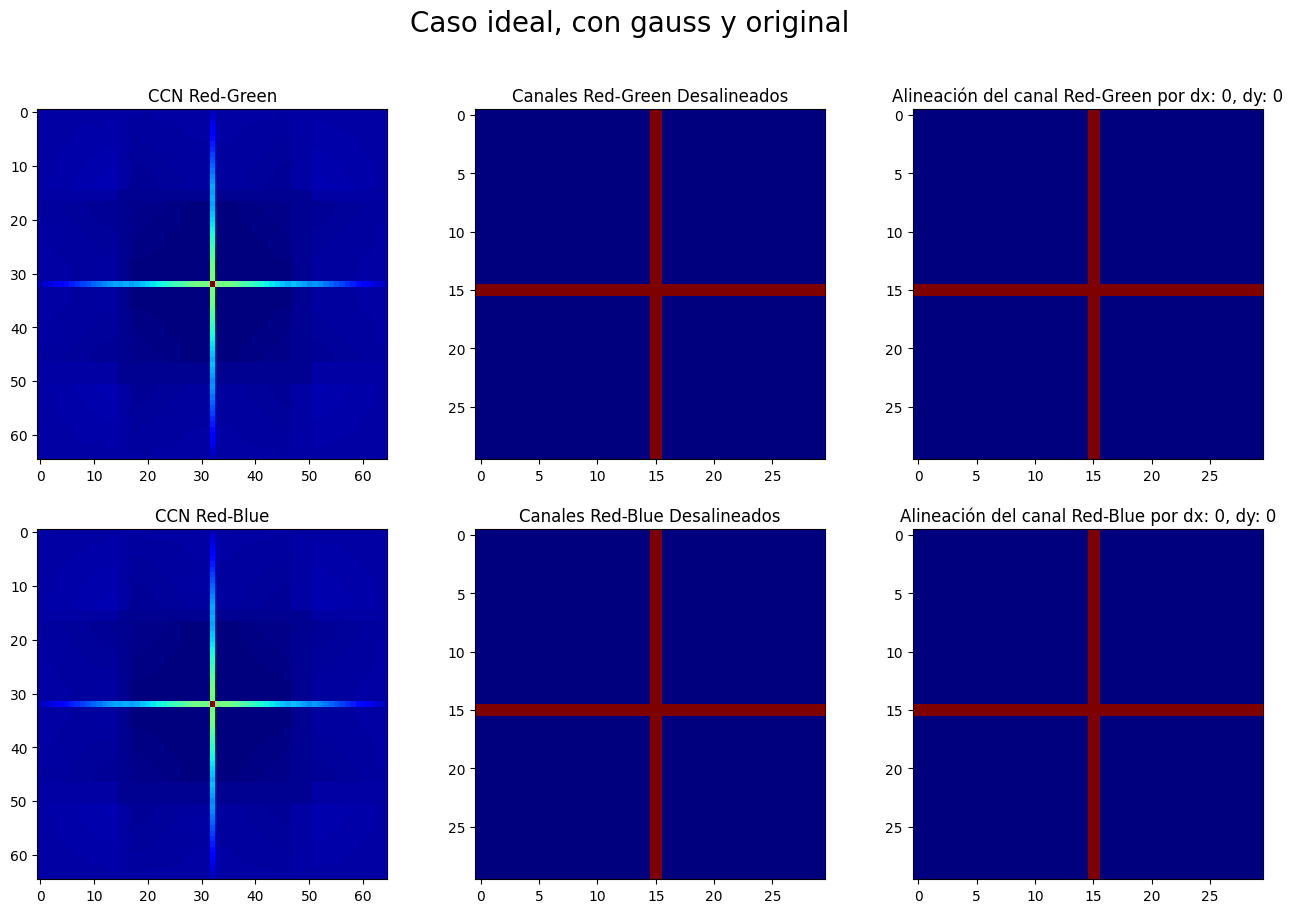

In [10]:
# Lo ejecutamos sin gauss
coords = (50, 50) # Centro de la imagen
ideal = pyramidal_descomposition(cruz_1, coords, 
                                 titles=[
                                    "Caso ideal, sin gauss y reducido",
                                    "Caso ideal, sin gauss y original"
                                  ],
                                  width=15, 
                                  gauss=False)

ideal_gauss = pyramidal_descomposition(cruz_1, coords, 
                                  titles=["Caso ideal, con gauss y reducido", 
                                          "Caso ideal, con gauss y original"], 
                                  width=15)


## Prueba 1 | Vamos a ejecutar la Cruz 2 con y sin gauss
- Recordemos que Cruz 2 tiene una cruz (Azul) fuera de la ventana 15x15 en la imagen original.
- Tambien tiene una cruz (verde) que al reducir la imagen desaparece

### Sin Gauss
Se ajustan todos los canales en la primera iteración sin problema, la segunda iteración es inútil.

### Con Gauss
Pasa exactamente lo mismo, se alinean en la primera iteración. Ya que los pixeles se ven claramente y no hemos perdido información al reducir el tamaño de la imagen.

Canal Green desalineado en [x, y]: -18, -18
Canal Blue desalineado en [x, y]: -12, -12
Canal Green desalineado en [x, y]: -18, -18
Canal Blue desalineado en [x, y]: 0, 0
Canal Green desalineado en [x, y]: 2, 1
Canal Blue desalineado en [x, y]: -12, -12
Canal Green desalineado en [x, y]: -1, 1
Canal Blue desalineado en [x, y]: 0, 0


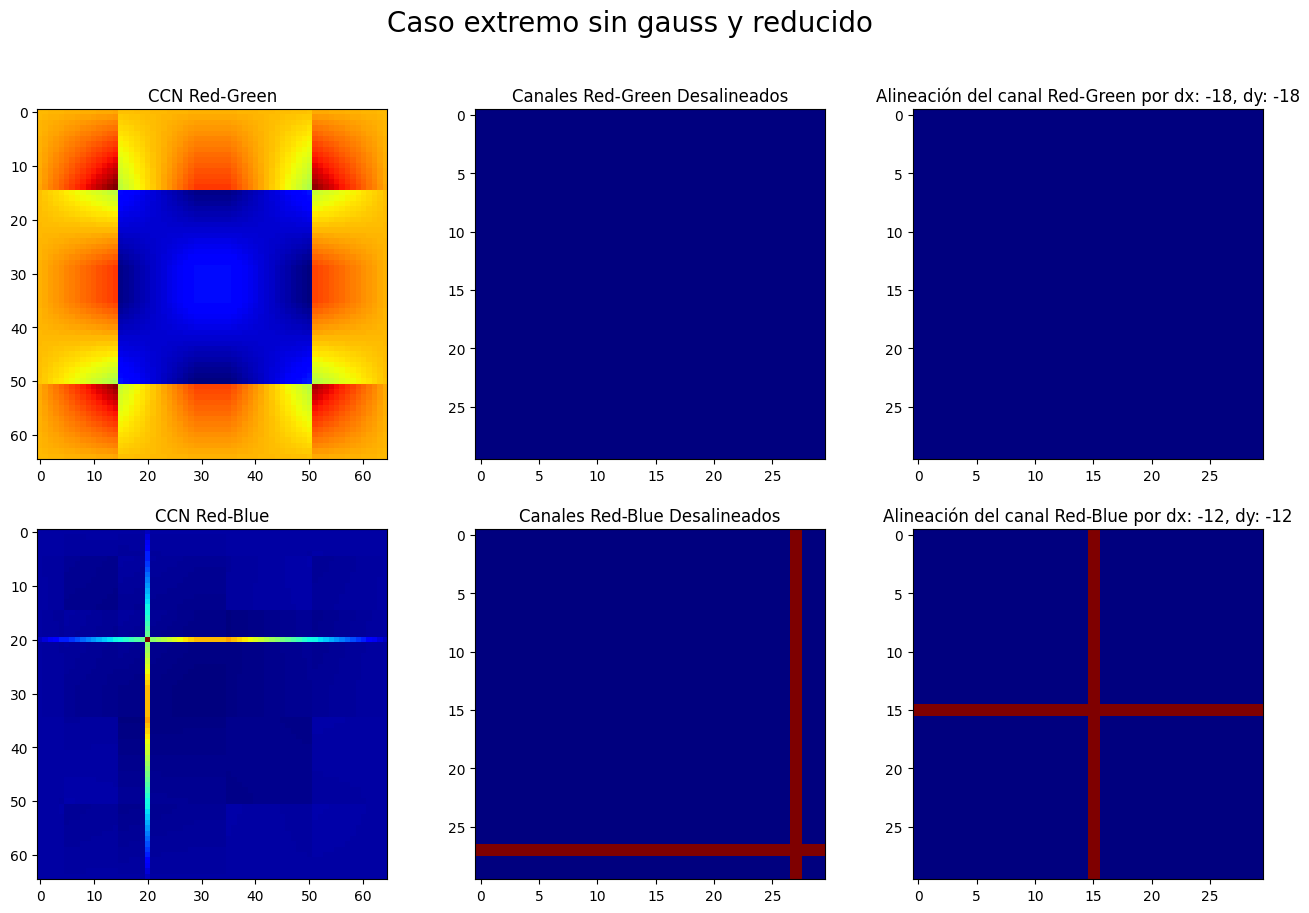

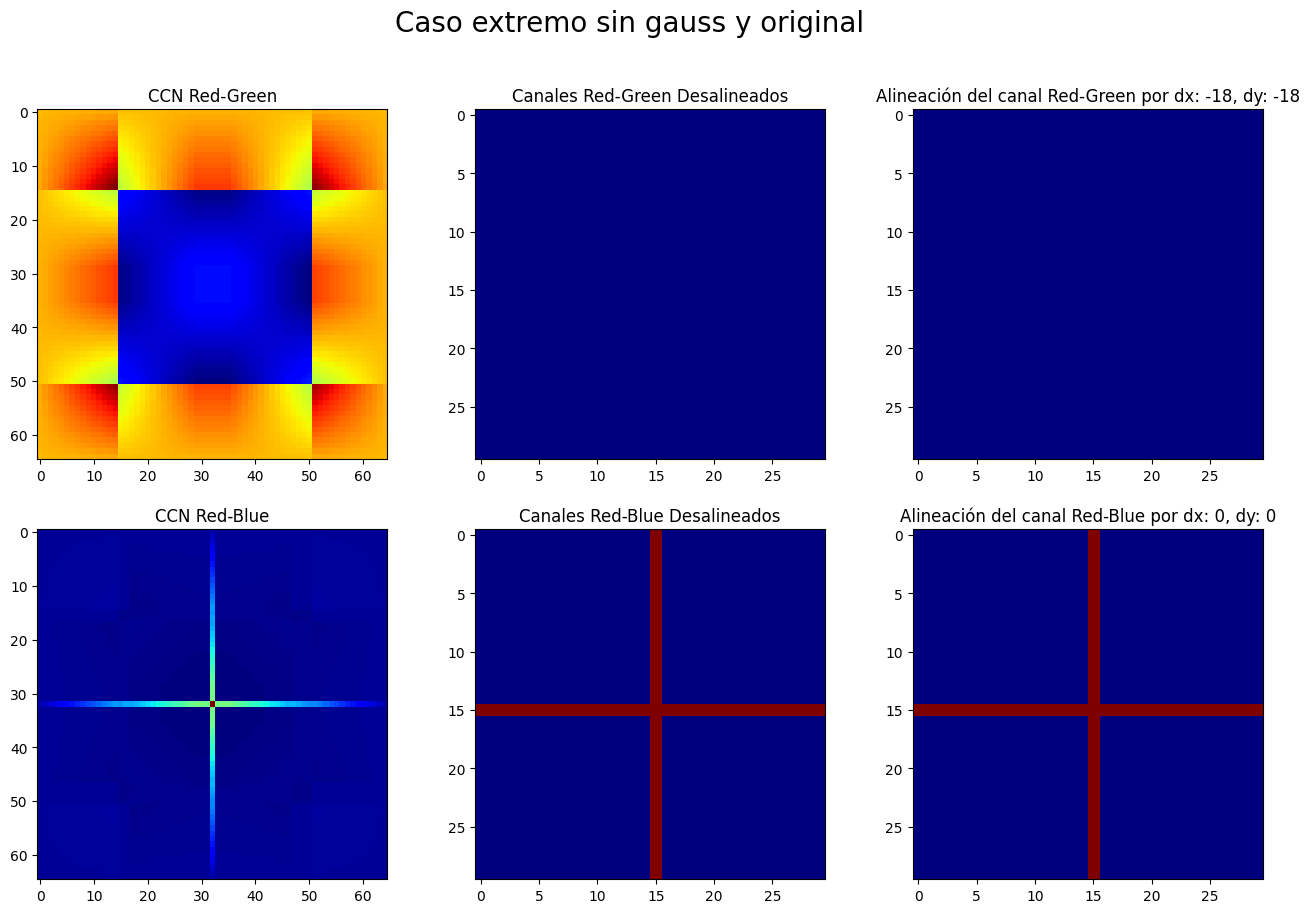

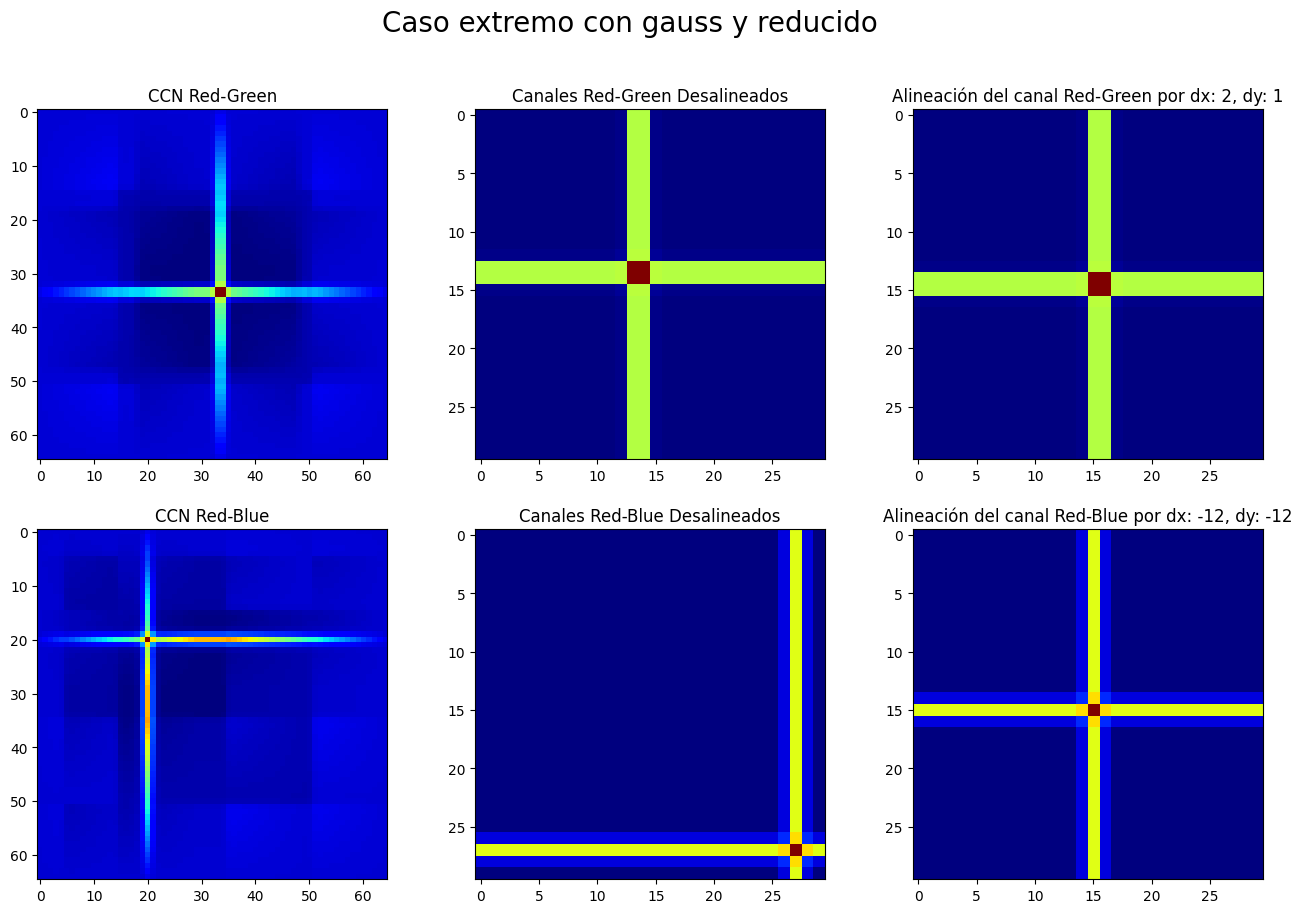

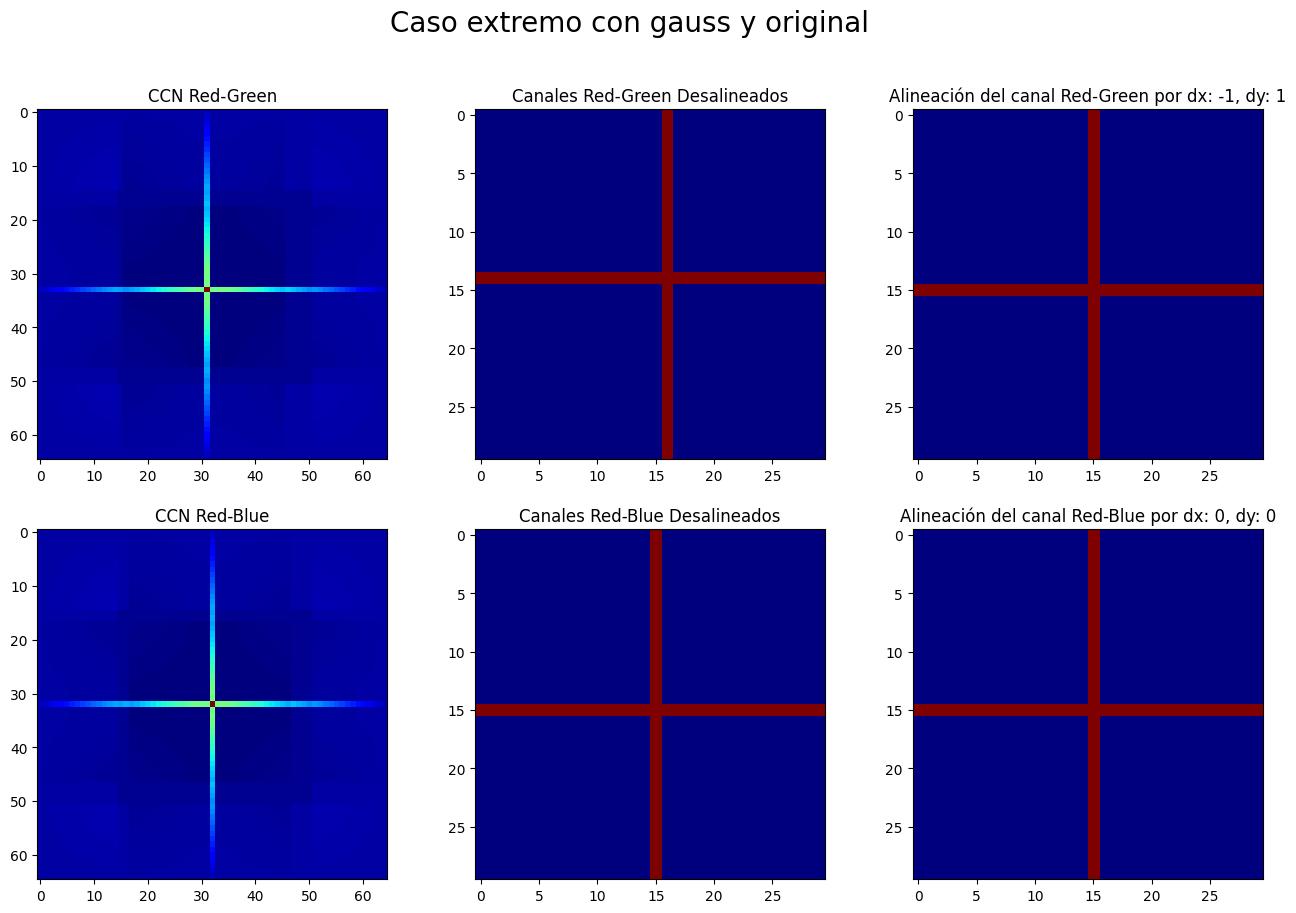

In [11]:
extremo = pyramidal_descomposition(cruz_2, coords,
                                  titles=["Caso extremo sin gauss y reducido", 
                                          "Caso extremo sin gauss y original"],
                                  width=15,
                                  gauss=False)

extremo_gauss = pyramidal_descomposition(cruz_2, coords,
                                  titles = [
                                    "Caso extremo con gauss y reducido", 
                                    "Caso extremo con gauss y original"],
                                  width=15)

## Resultados

Podemos ver como la importancia del gauss reside en que perdemos menos información. En el caso extremo, los pixeles verdes que aportan toda la información de el desplazamiento se han perdido, por lo tanto no se encuentra ningun tipo de desplazamiento. Al aplicar gauss si se encuentra.

Ademas si no hicieramos el primer paso de la piramide, la cruz azul no se veria. Pues no esta en el cuadro de busqueda en el que estamos buscando. Al reducir la imagen, "es como si estuvieramos ampliando el lugar de busqueda" pero sin ampliar la resolución, disminuyendo el coste computacional.

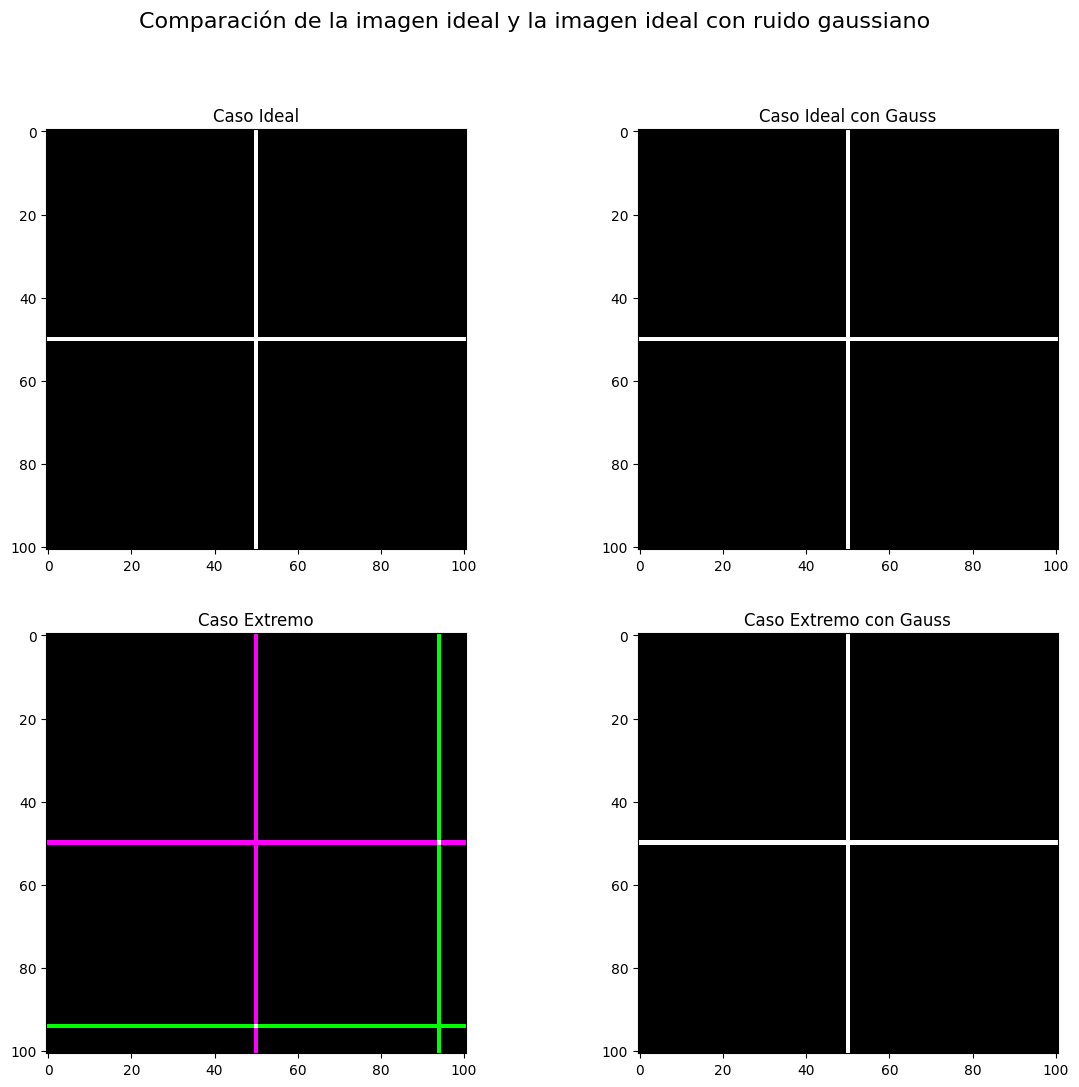

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

fig.suptitle("Comparación de la imagen ideal y la imagen ideal con ruido gaussiano", fontsize=16)

axes[0, 0].imshow(ideal)
axes[0, 0].set_title('Caso Ideal')

axes[0, 1].imshow(ideal_gauss)
axes[0, 1].set_title('Caso Ideal con Gauss')

axes[1, 0].imshow(extremo)
axes[1, 0].set_title('Caso Extremo')

axes[1, 1].imshow(extremo_gauss)
axes[1, 1].set_title('Caso Extremo con Gauss')

plt.show()

# Prueba 2 | Vamos a comprobarlo con la imagen original
### Preparación
Para esto, necesitamos la imagen con la que estamos trabajando, pero vamos desplazar el canal rojo en los 3 canales.

### Objetivo
Si funciona correctamente, la funcion deberia devolvernos la imagen en blanco y negro, e imprimirnos por pantalla los dx, dy de cada paso.

In [13]:
x = 167
y = 135
width = 15
test_img = np.stack([
    im[... ,0 ].copy(),
    roll(im[..., 0].copy(), 4, 0),
    roll(im[..., 0].copy(), -15, 1)
], axis=2)

obj_img = np.stack([
    im[..., 0].copy(),
    im[..., 0].copy(),
    im[..., 0].copy()], axis=2)

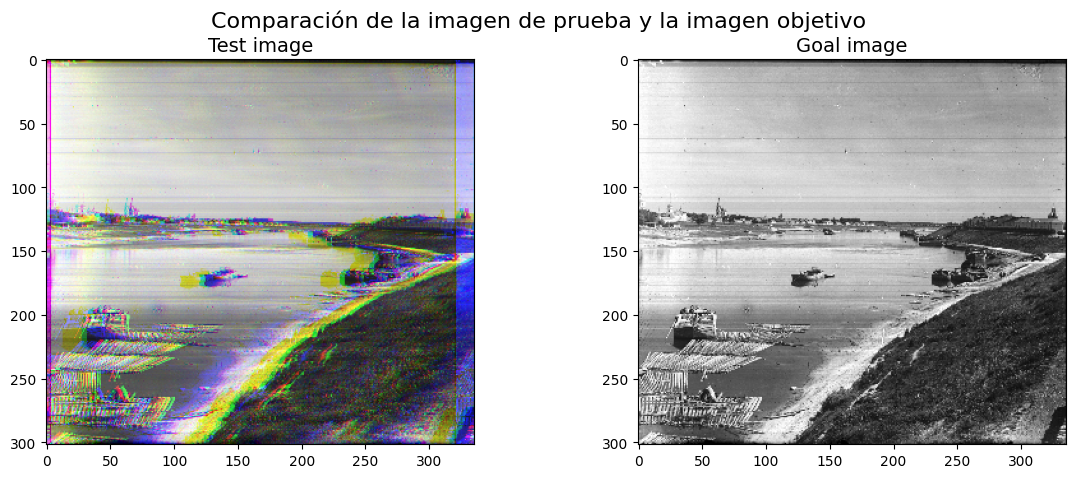

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle("Comparación de la imagen de prueba y la imagen objetivo", fontsize=16)

axes[0].imshow(test_img)
axes[0].set_title('Test image', fontsize=14)

axes[1].imshow(obj_img)
axes[1].set_title('Goal image', fontsize=14)

plt.show()

Canal Green desalineado en [x, y]: -2, 0
Canal Blue desalineado en [x, y]: 7, 0
Canal Green desalineado en [x, y]: 0, 0
Canal Blue desalineado en [x, y]: 1, -1


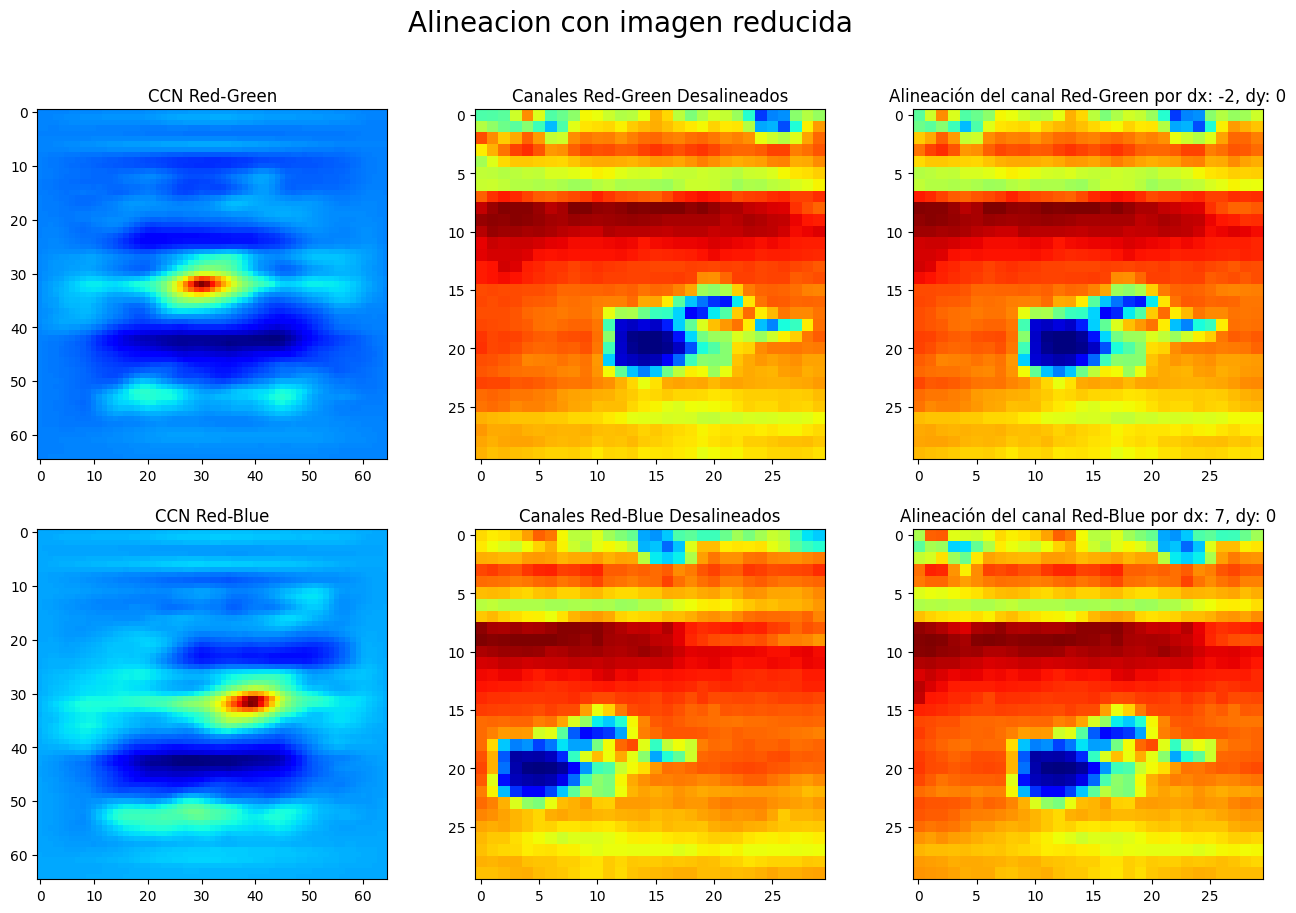

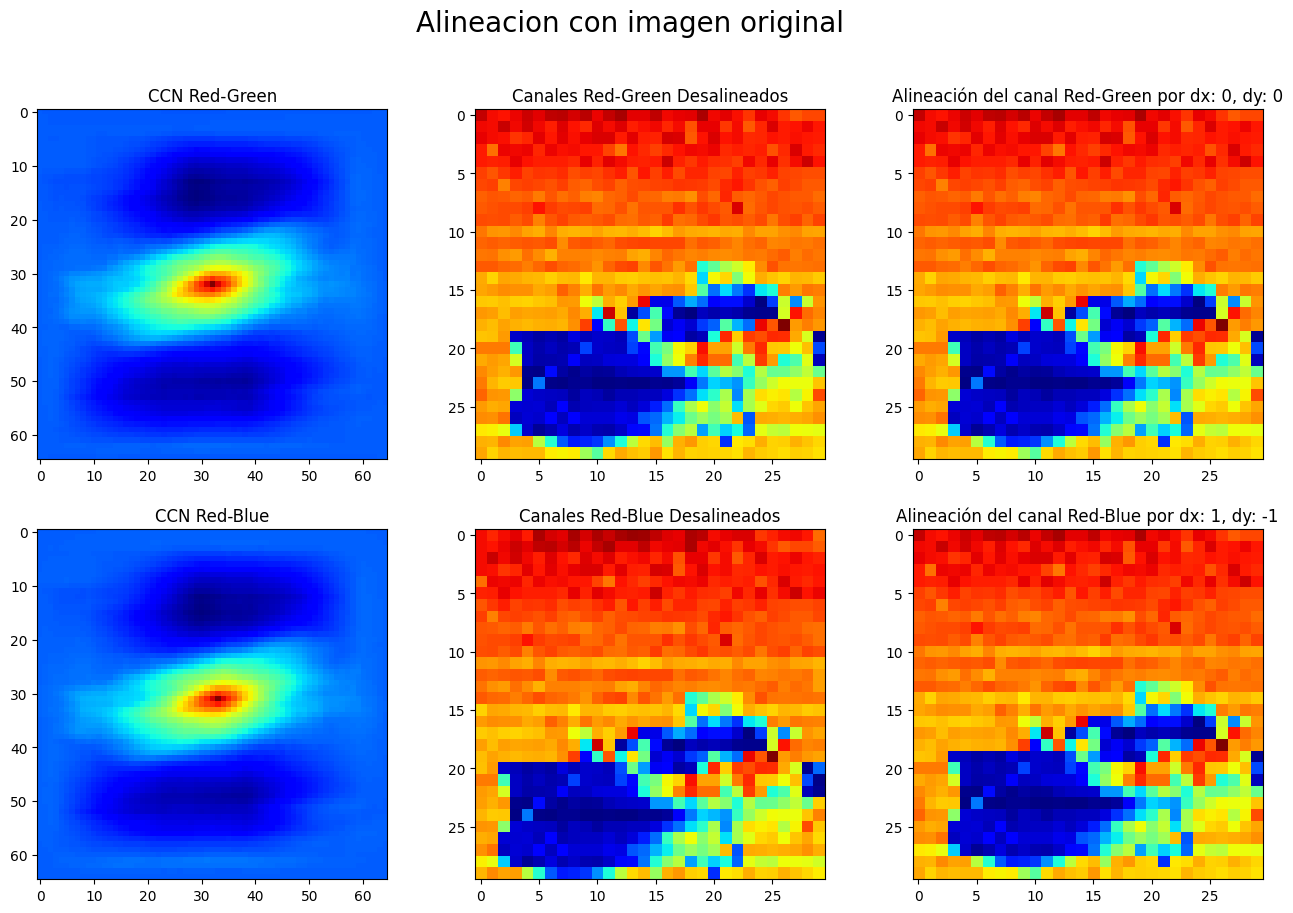

In [15]:
# Aplicamos la función pyramidal_descomposition a las imágenes de prueba
goal_img_achived = pyramidal_descomposition(test_img, (132, 165), ["Alineacion con imagen reducida", "Alineacion con imagen original"])


### Comprovación

Como podemos ver en la imagen de abajo, funciona perfectamente, y la función nos muestra los pixeles que se han desplazado en cada iteración, que corresponden al doble de los pixeles que se han movido intencionalmente para la parte reducida.

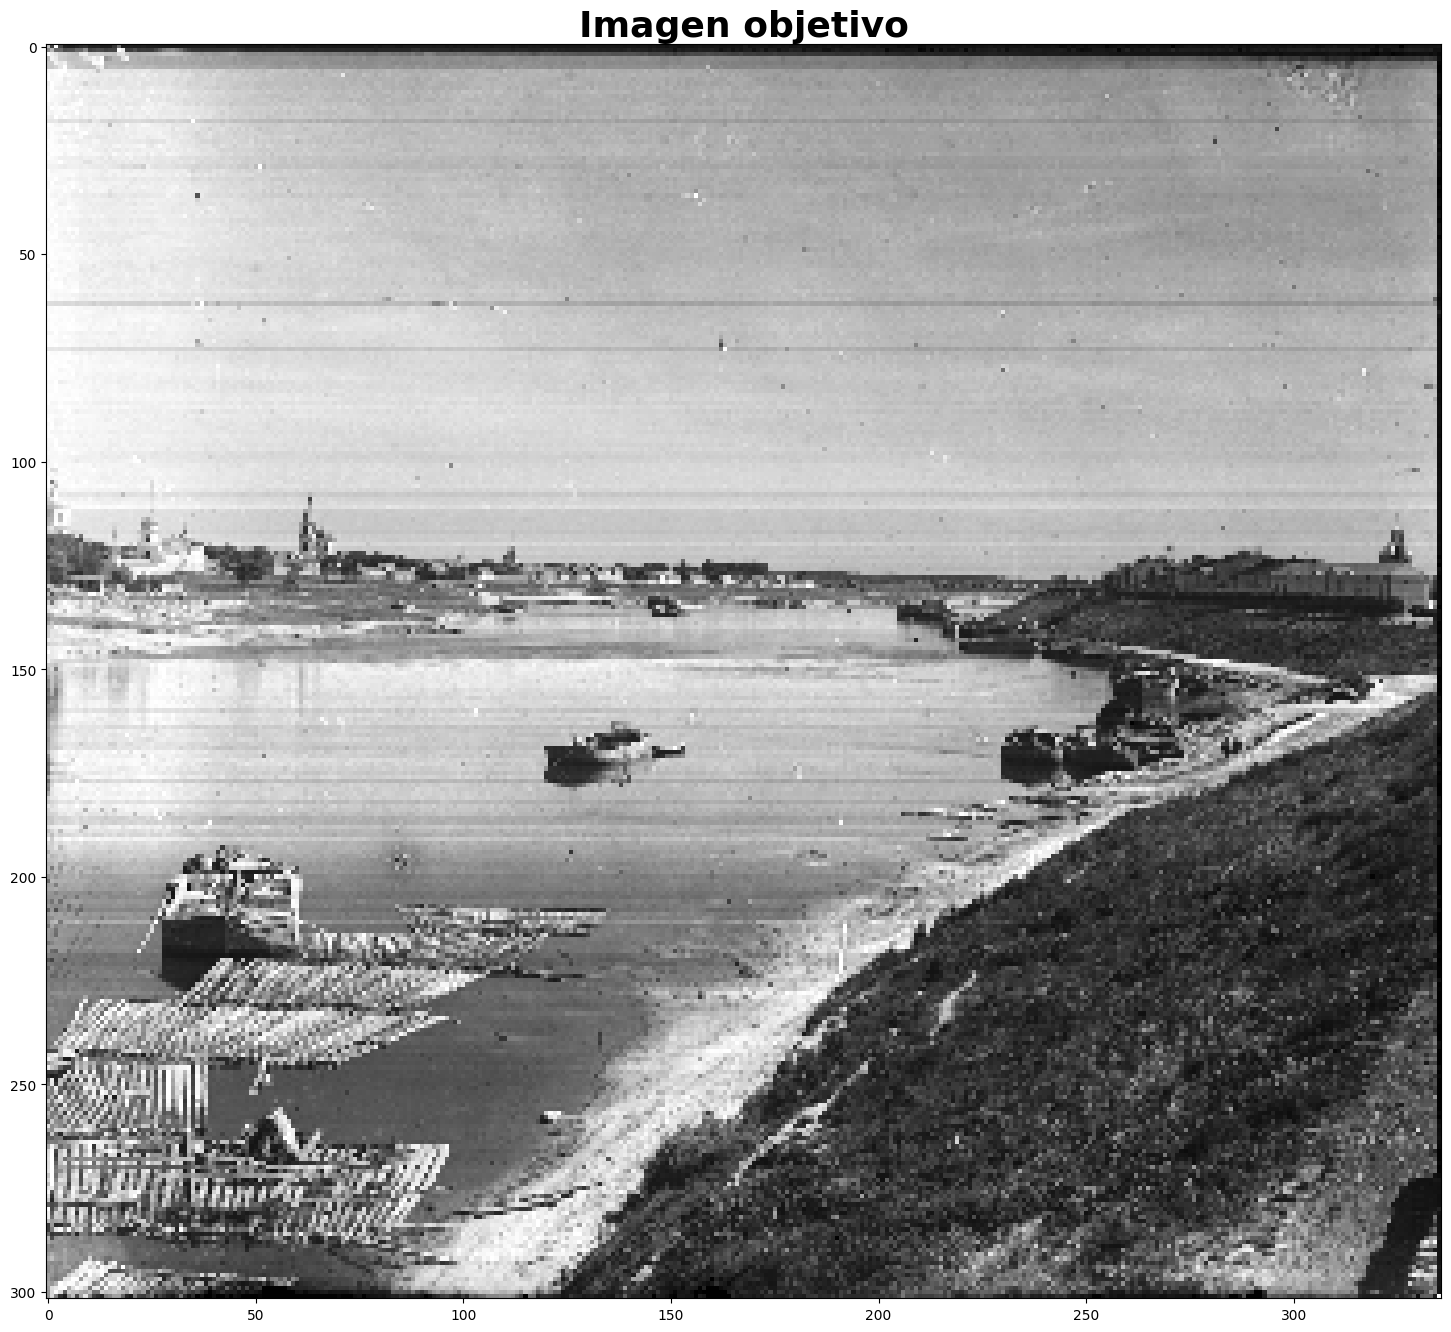

In [16]:
# Imagen objetivo
fig = plt.figure(figsize=(18, 18))
plt.title("Imagen objetivo", fontsize=26, fontweight='bold')
plt.imshow(goal_img_achived)

## Ahora realizamos los pasos con la imagen a tamaño original

In [17]:
img_ = io.imread("rusian_empire.png")
x1 = 200; y1 = 200;
x2 = 250; y2 = 3330;
x3 = 240; y3 = 6470;
w = 3360; h = 3020;

img = np.stack([
    img_[y3-2:y3+h-2,x3-1:x3+w-1],
    img_[y2-2:y2+h-2,x2-1:x2+w-1],
    img_[y1-2:y1+h-2,x1-1:x1+w-1],
], axis=2)

im = np.apply_along_axis(lambda x: x.astype(np.double) / x.max(), arr=img, axis=1)

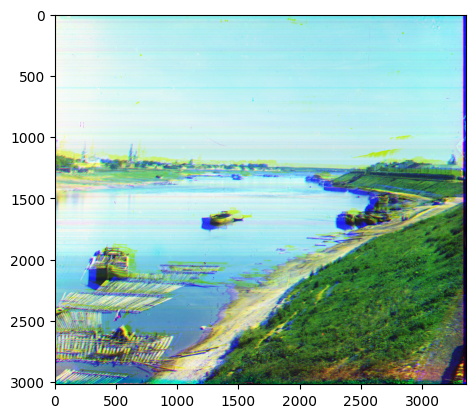

In [18]:
plt.imshow(im)

### Ejecutamos apply_cross_correlation en la imagen original

Canal Green desalineado en [x, y]: -8, 4
Canal Blue desalineado en [x, y]: -76, 32


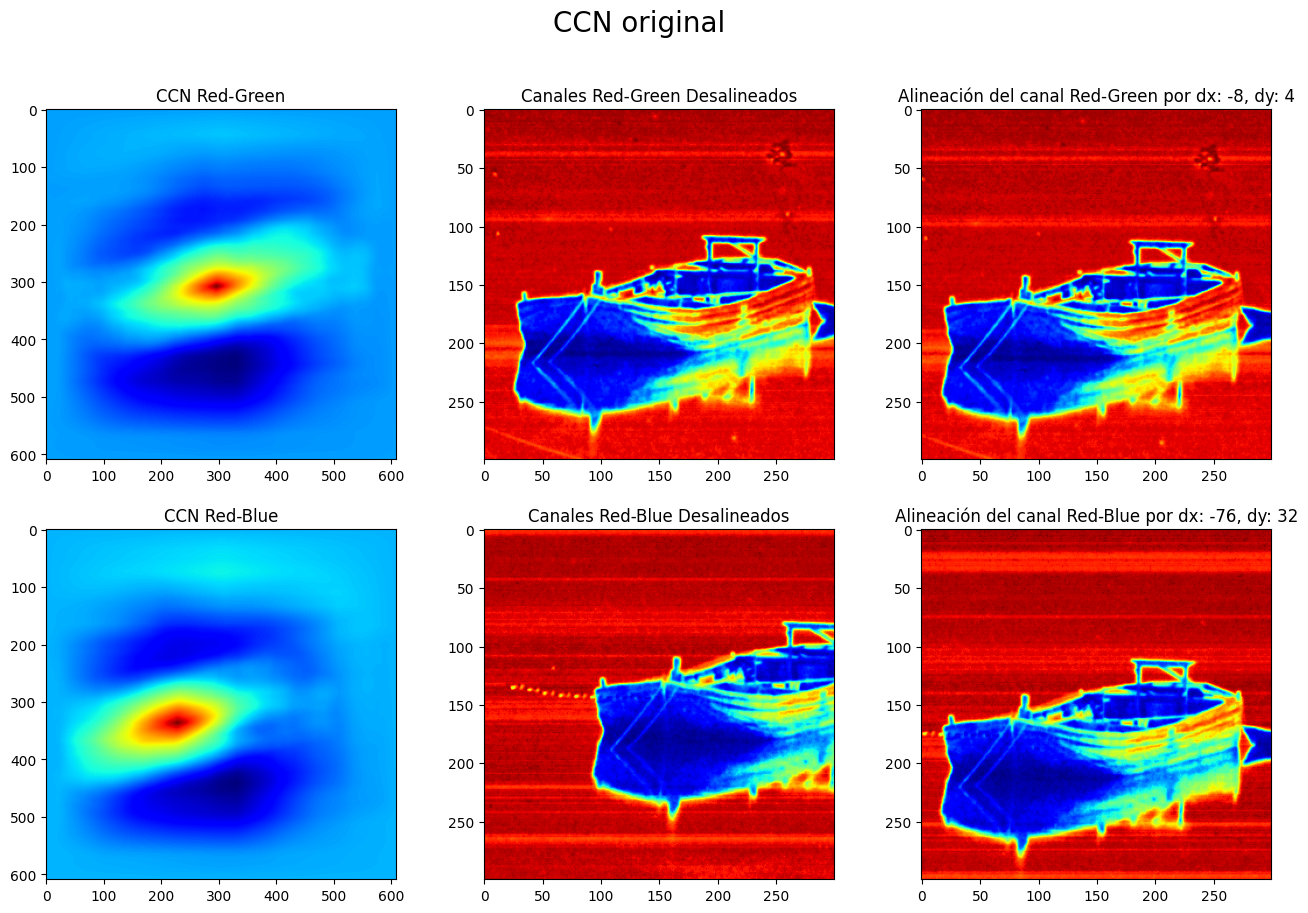

In [19]:
ccn_original = apply_cross_correlation(im, (1320, 1650), "CCN original", width=150, search=5)

Al ejecutar la `pyramidal_descomposition` podemos cubrir un tamaño de búsqueda más grande con una complejidad computacional mucho más reducida. Ya que si tuviéramos que hacer el doble de `width` para buscar una zona más grande estaríamos haciendo $n^2$ operaciones. Ya que tenemos que aplicar operaciones en cada uno de esos pixeles (cross correlation) y al ser un area aumenta al cuadrado.

En cambio de esta forma estamos haciendo $2n$, con la misma width inicial.

En la imagen original no tiene utilidad ya que la desviación de los canales no sale del cuadro de busqueda,

Canal Green desalineado en [x, y]: -4, 2
Canal Blue desalineado en [x, y]: -39, 16
Canal Green desalineado en [x, y]: -1, 0
Canal Blue desalineado en [x, y]: 1, 1


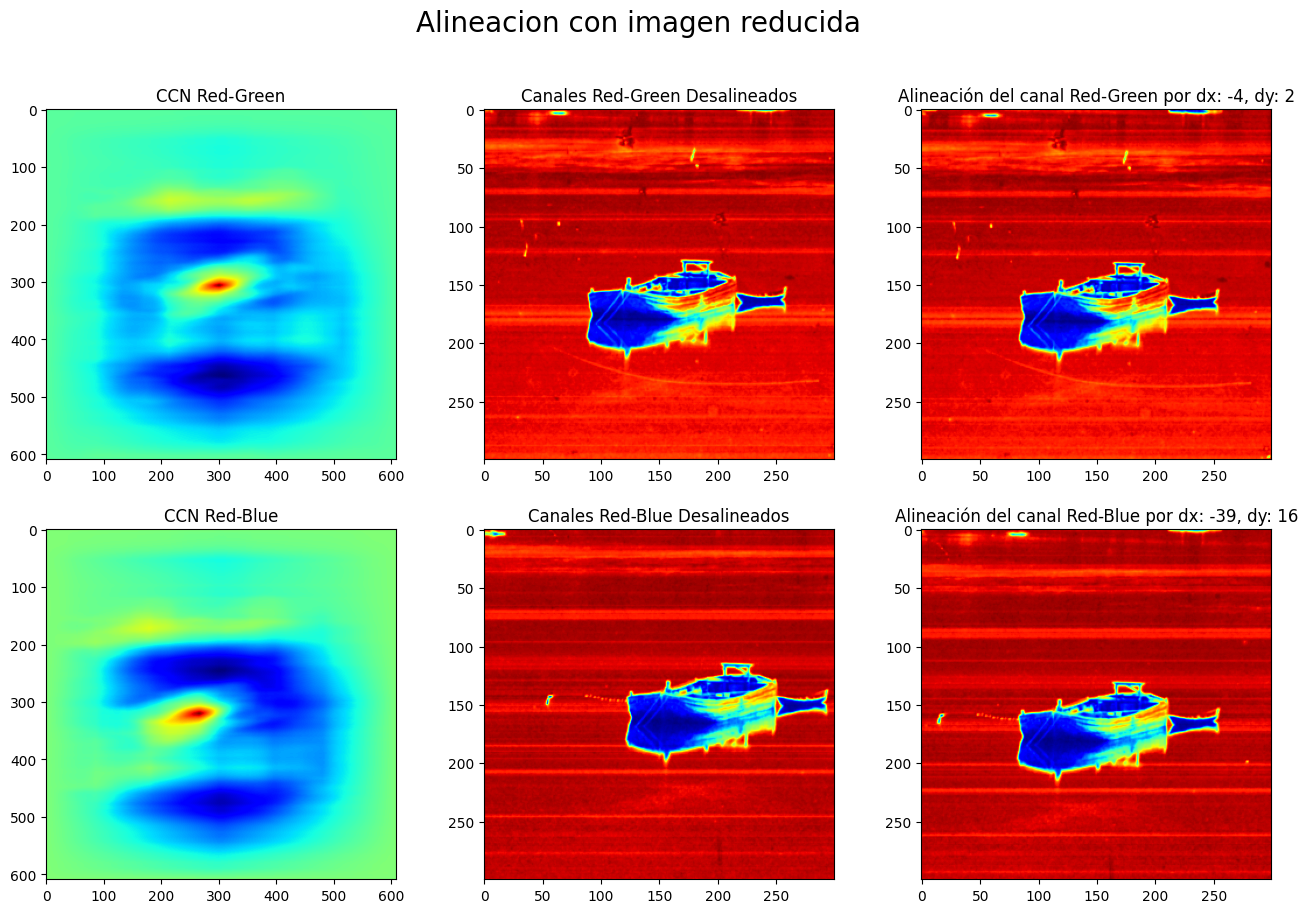

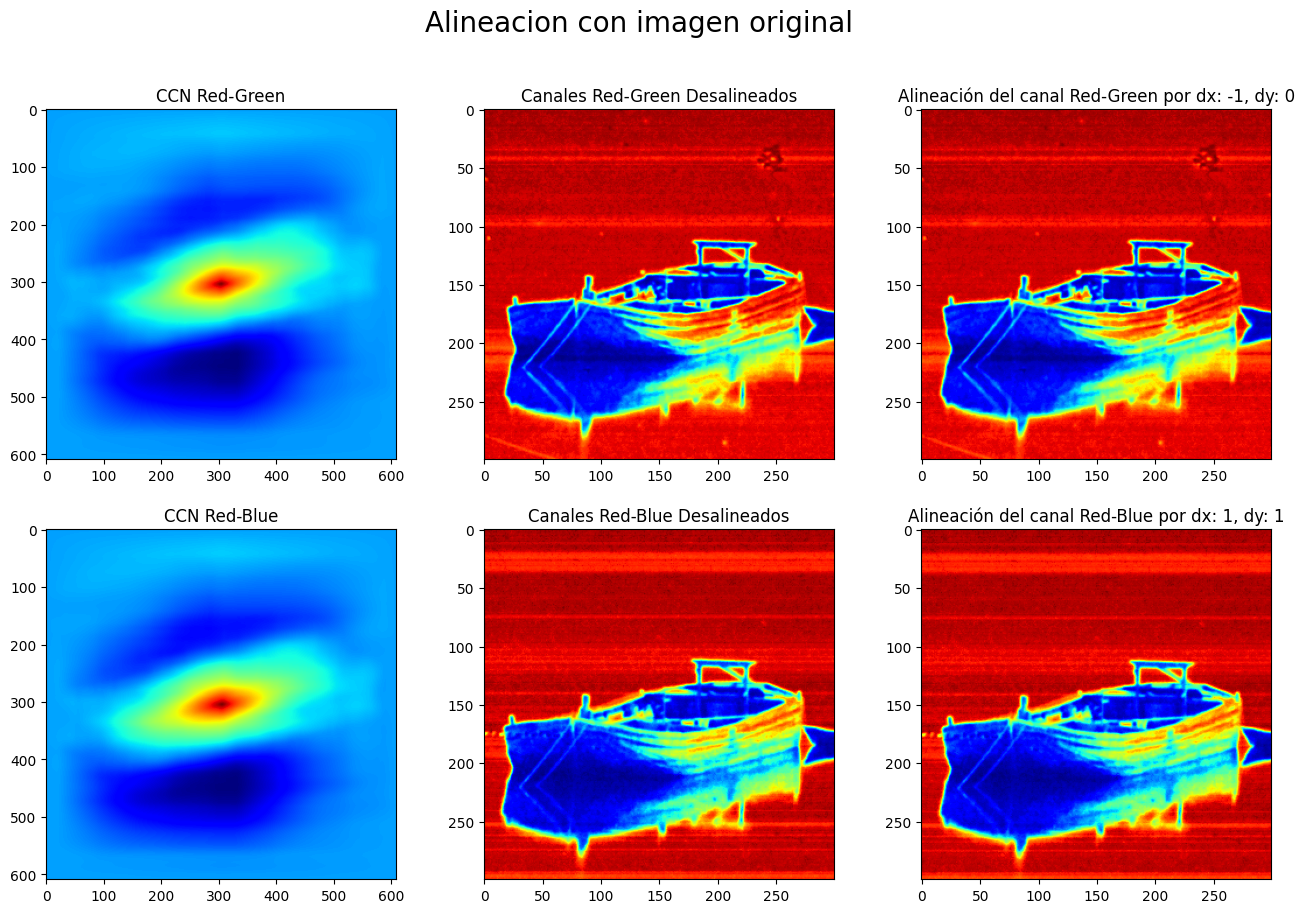

In [20]:
#Pyramidal descomposition
goal_img_achived = pyramidal_descomposition(im, coords=(1320, 1650), titles=["Alineacion con imagen reducida", "Alineacion con imagen original"], width=150, search=5)

# Imagen final alineada.

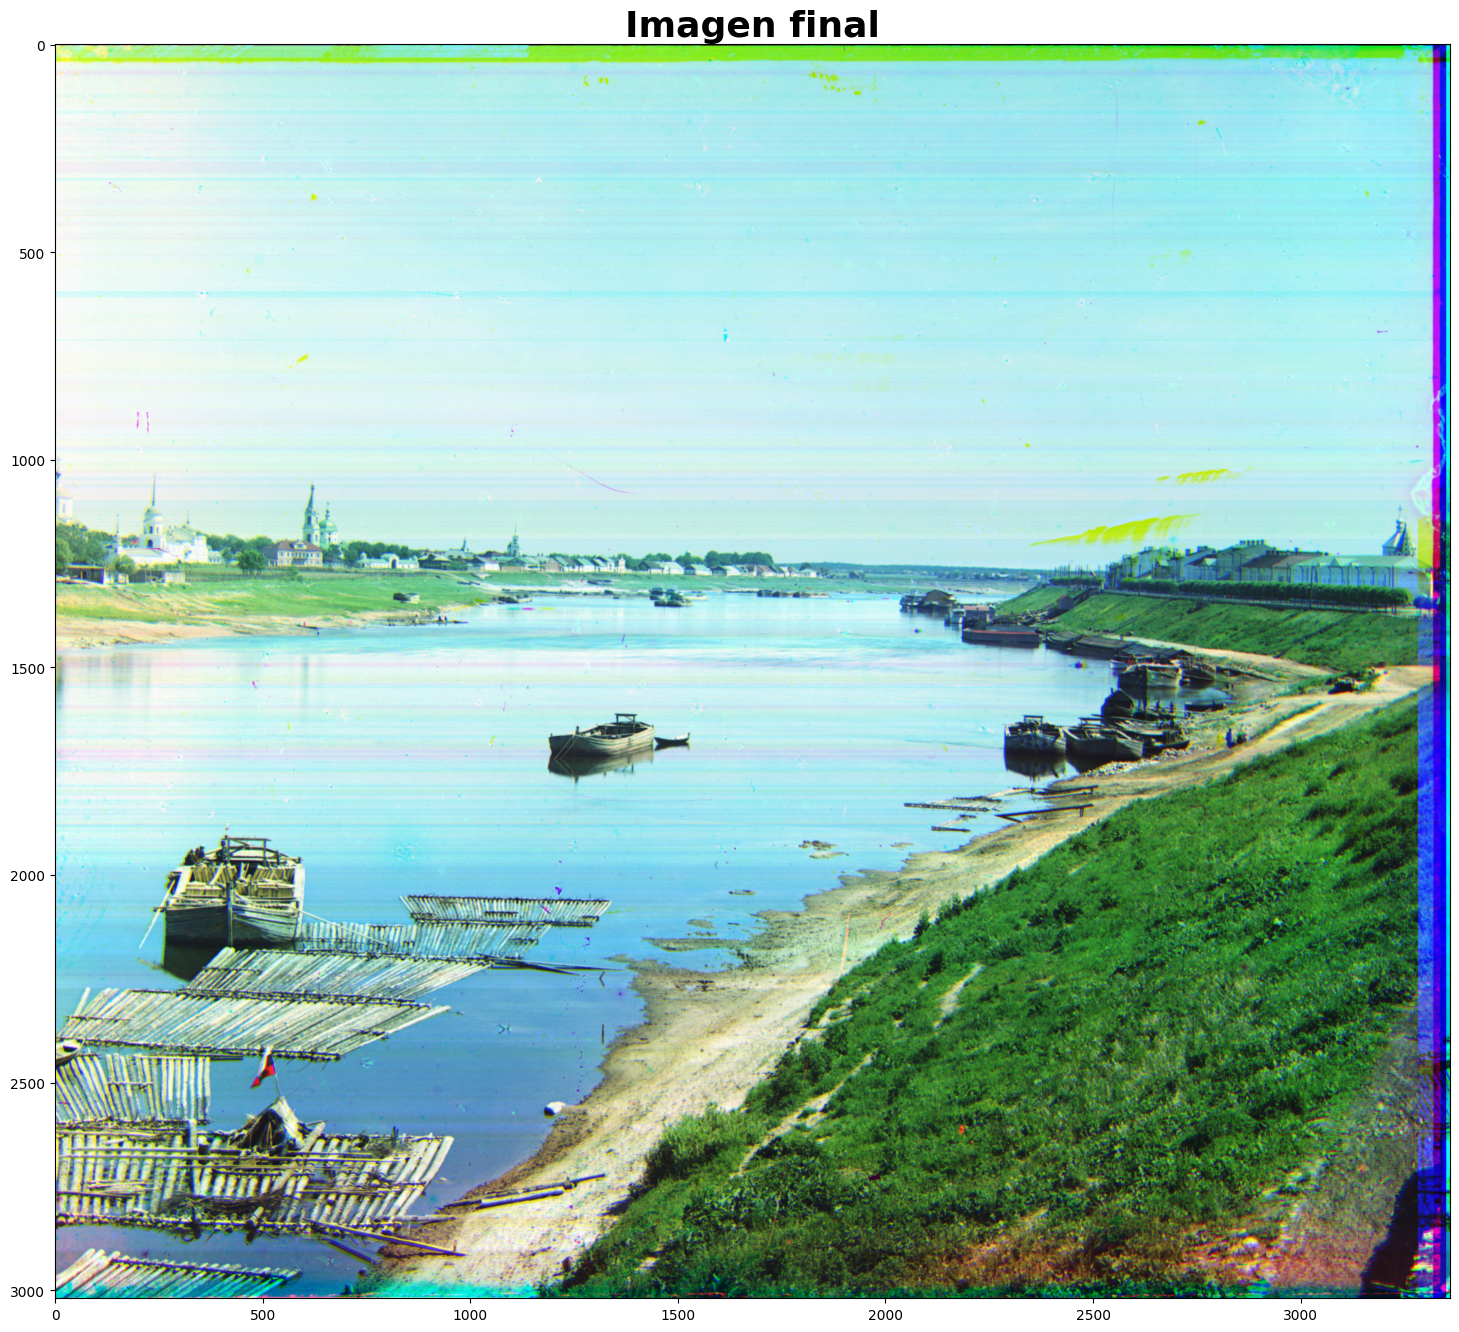

In [21]:
fig = plt.figure(figsize=(18, 18))
plt.title("Imagen final", fontsize=26, fontweight='bold')
plt.imshow(goal_img_achived)